# COVID-19 detection using Chest X-rays

Dataset obtained from: https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset/

---

## Requirements

In [1]:
# Basic dataframe and array manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding
from scipy.spatial import procrustes

# Model performance
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import silhouette_score

# To deal with unnecesary warning Warnings
import warnings
warnings.simplefilter("ignore")

# Reading images
from PIL import Image
import os

# Clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Neural network (Keras and Tensorflow)
import keras
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import layers

# Time
import time

In [2]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

def plot_decision_boundaries_without_points(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

#### Training data

In [3]:
def read_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    img = np.array(img, dtype='float32')
    img = img/255 # normalization
    return img

In [4]:
X_train = []
y_train = []

path = 'drive/MyDrive/Covid19-dataset/train'
train_path = os.listdir(path)

for folder in train_path:
  folder_path = os.path.join(path, folder)
  if os.path.isdir(folder_path):
    for img in os.listdir(folder_path):
        X_train.append(read_image(folder_path + '/' + img))
        if folder[0] == 'C':
            y_train.append('C') # Covid
        elif folder[0] == 'V':
            y_train.append('P') # Pneumonia
        else:
            y_train.append('N') # Normal

In [5]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train.shape

(251, 256, 256)

<BarContainer object of 3 artists>

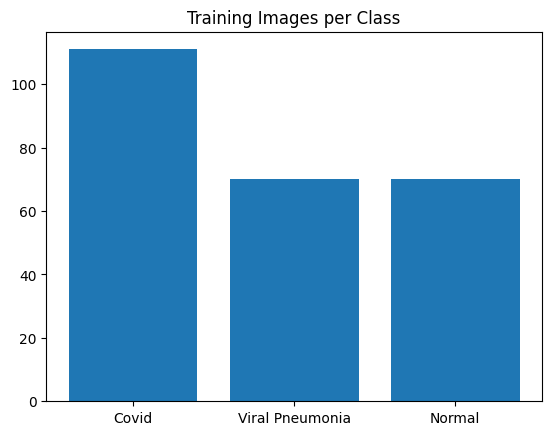

In [6]:
covid = len(y_train[y_train=='C'])
pneumonia = len(y_train[y_train=='P'])
normal = len(y_train[y_train=='N'])

plt.title("Training Images per Class")
plt.bar(["Covid", "Viral Pneumonia", "Normal"],[covid, pneumonia, normal])

## PCA

In [7]:
X_train.shape

(251, 256, 256)

In [8]:
num_images, _ ,_ = X_train.shape
X = np.array(X_train.reshape(num_images, -1))

In [9]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [10]:
d

126

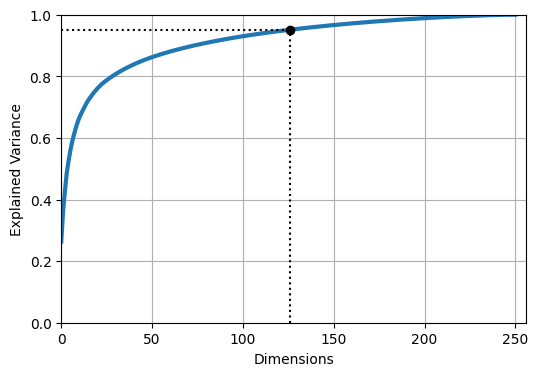

In [11]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 256, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.grid(True)
plt.show()

In [12]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)
pca.n_components_

126

In [13]:
np.sum(pca.explained_variance_ratio_)

0.95063263

*   **126** components are needed to preserve 95% of the variance.

In [14]:
pca = PCA(n_components=126)
X_reduced = pca.fit_transform(X)
X_recovered = pca.inverse_transform(X_reduced)

Text(0.5, 1.0, 'Compressed')

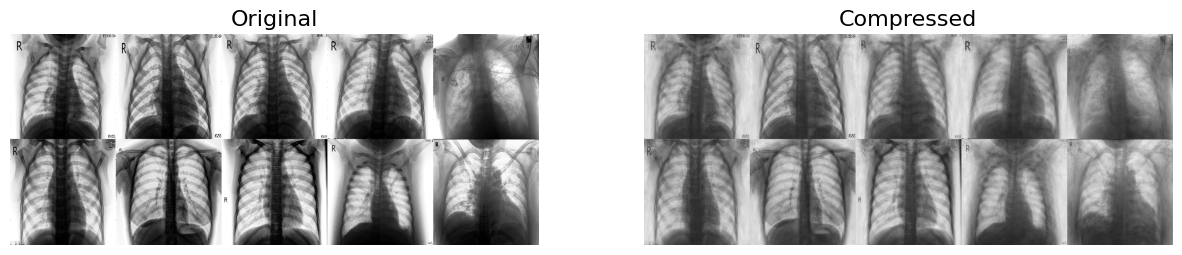

In [15]:
def plot_rocks(instances, images_per_row=5, **options):
    size = 256
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1

    n_empty = n_rows * images_per_row - len(instances)

    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)

    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

# plot random 10 rocks
random_indices = np.random.choice(len(X), 10, replace=False)
plt.figure(figsize=(15, 10))
plt.subplot(121)
plot_rocks(X[random_indices])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_rocks(X_recovered[random_indices])
plt.title("Compressed", fontsize=16)


In [16]:
pca = PCA(n_components=2)
X_reduced_pca = pca.fit_transform(X)

In [17]:
pca.explained_variance_ratio_

array([0.26353064, 0.10000829], dtype=float32)

*   The first component explains 26.35% of the variance, and the second one explains 10.00% of the variance.

**PCA**

In [18]:
categories = np.unique(y_train)
colors = ['#D53838', '#67BB60', '#3887D5']
images = [x.reshape(256, 256) for x in X_train[:50]]

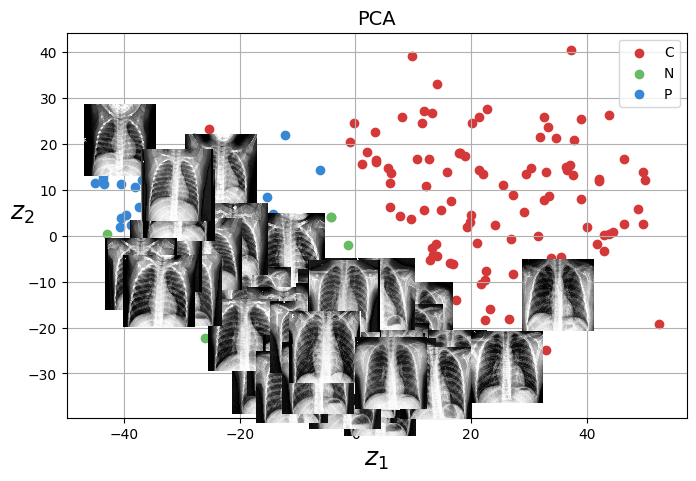

In [19]:
plt.figure(figsize=(8,5))

plt.title("PCA", fontsize=14)

for category, color in zip(categories, colors):
    indices = y_train == category
    plt.scatter(X_reduced_pca[indices, 0], X_reduced_pca[indices, 1], c=color, label=category)

# x-ray images
for i, (img, xy) in enumerate(zip(X_train, X_reduced_pca[:50])):
    imagebox = OffsetImage(img, cmap=plt.get_cmap('gray'), zoom=0.2)
    ab = AnnotationBbox(imagebox, xy, frameon=False)
    plt.gca().add_artist(ab)

plt.legend()

plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()


**t-SNE**

In [20]:
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

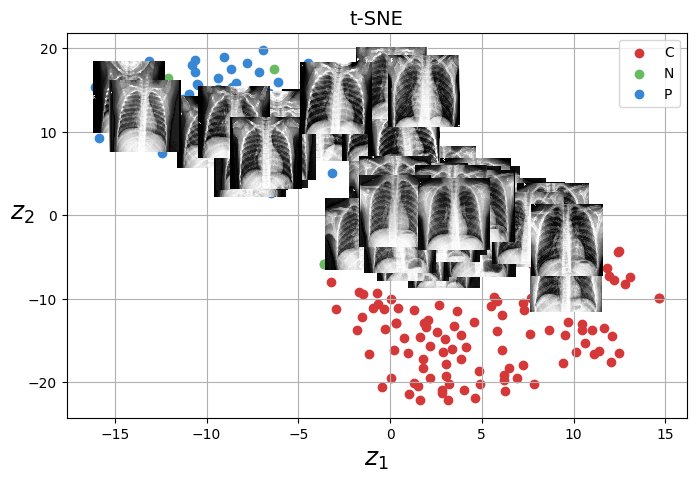

In [21]:
plt.figure(figsize=(8,5))

plt.title("t-SNE", fontsize=14)

for category, color in zip(categories, colors):
    indices = y_train == category
    plt.scatter(X_reduced_tsne[indices, 0], X_reduced_tsne[indices, 1], c=color, label=category)

# x-ray images
for i, (img, xy) in enumerate(zip(X_train, X_reduced_tsne[:50])):
    imagebox = OffsetImage(img, cmap=plt.get_cmap('gray'), zoom=0.2)
    ab = AnnotationBbox(imagebox, xy, frameon=False)
    plt.gca().add_artist(ab)

plt.legend()

plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

**LLE**

In [22]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced_lle = lle.fit_transform(X)

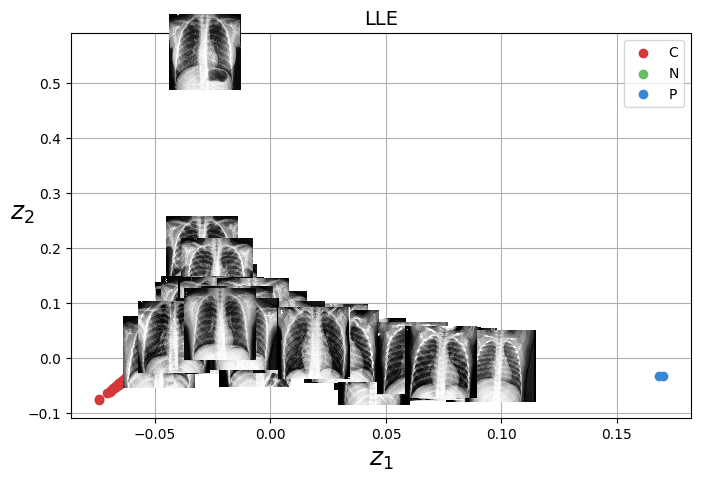

In [23]:
plt.figure(figsize=(8,5))

plt.title("LLE", fontsize=14)

for category, color in zip(categories, colors):
    indices = y_train == category
    plt.scatter(X_reduced_lle[indices, 0], X_reduced_lle[indices, 1], c=color, label=category)

# x-ray images
for i, (img, xy) in enumerate(zip(X_train, X_reduced_lle[:50])):
    imagebox = OffsetImage(img, cmap=plt.get_cmap('gray'), zoom=0.2)
    ab = AnnotationBbox(imagebox, xy, frameon=False)
    plt.gca().add_artist(ab)

plt.legend()

plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()


**MDS**

In [24]:
mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

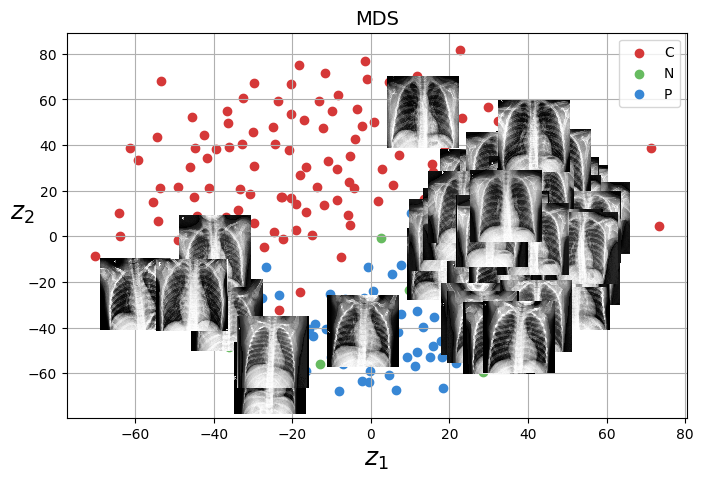

In [25]:
plt.figure(figsize=(8,5))

plt.title("MDS", fontsize=14)

for category, color in zip(categories, colors):
    indices = y_train == category
    plt.scatter(X_reduced_mds[indices, 0], X_reduced_mds[indices, 1], c=color, label=category)

# x-ray images
for i, (img, xy) in enumerate(zip(X_train, X_reduced_mds[:50])):
    imagebox = OffsetImage(img, cmap=plt.get_cmap('gray'), zoom=0.2)
    ab = AnnotationBbox(imagebox, xy, frameon=False)
    plt.gca().add_artist(ab)

plt.legend()

plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

*   By the looks of it, MDS seems to capture the most diverse set of distinct visual properties of the x-ray images (contrast, brightness...). It also clusters images of similar features together (e.g., lighter images on the left, images with light covering segments of the lungs in the bottom left...). This shows that it preserves intrinsic similarities present in the original images. For those reasons, MDS is elected to be the best reduction technique. t-SNE would be a close second.

## Clustering

In [26]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)
np.sum(pca.explained_variance_ratio_)

0.3635387

**Determining the number of clusters using silhouette scores**

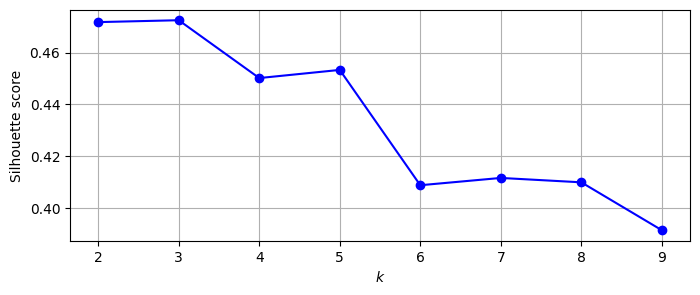

In [27]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X2D)
                for k in range(1, 10)]
silhouette_scores = [silhouette_score(X2D, model.labels_)
                     for model in kmeans_per_k[1:]]
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.grid()
plt.show()

*  **3** seems to be the ideal number of clusters.

In [28]:
kmeans = KMeans(n_clusters=3, random_state=42)
y_pred = kmeans.fit_predict(X=X2D.astype('double'))
kmeans.cluster_centers_

array([[-28.03885424,   3.90879427],
       [ 25.29619465,   8.49071818],
       [  3.5214061 , -22.74488654]])

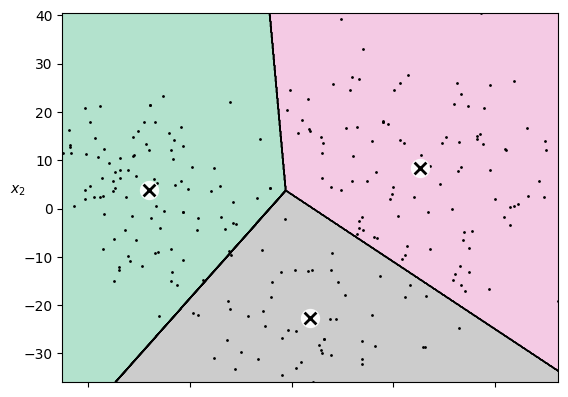

In [29]:
plot_decision_boundaries(kmeans, X2D, show_centroids=True, show_xlabels=False)

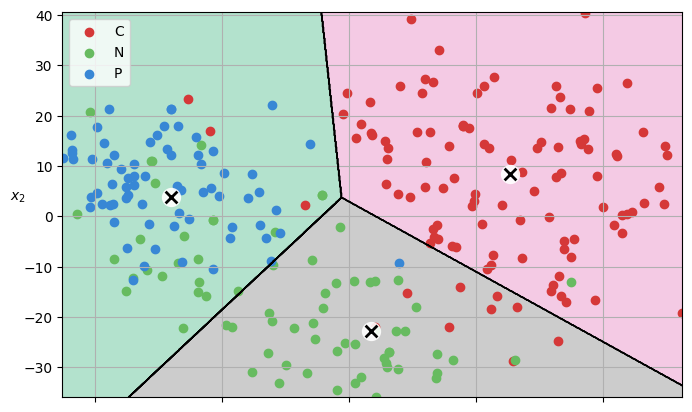

In [30]:
plt.figure(figsize=(8,5))
plot_decision_boundaries_without_points(kmeans, X2D, show_centroids=True,
                         show_xlabels=False)

for category, color in zip(categories, colors):
    indices = y_train == category
    plt.scatter(X2D[indices, 0], X2D[indices, 1], c=color, label=category)

plt.legend()

plt.grid(True)
plt.show()

## Clustering using EM

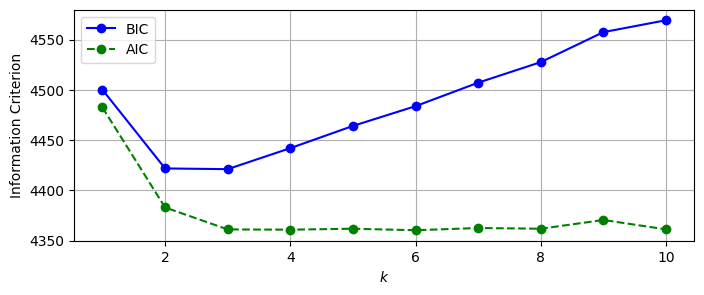

In [31]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X2D)
             for k in range(1, 11)]
bics = [model.bic(X2D) for model in gms_per_k]
aics = [model.aic(X2D) for model in gms_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$")
plt.ylabel("Information Criterion")
plt.legend()
plt.grid()
plt.show()

*  For BIC the minimum is at 2 and 3, whereas for AIC the minimum seems to be 4. However, since the minimum at k = 3 seems to be super close to the absolute minimum, 3 could be selected as the right number of clusters.


In [32]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X2D)

GaussianMixture(n_components=3, n_init=10, random_state=42)

In [33]:
y_pred = gm.predict(X2D)

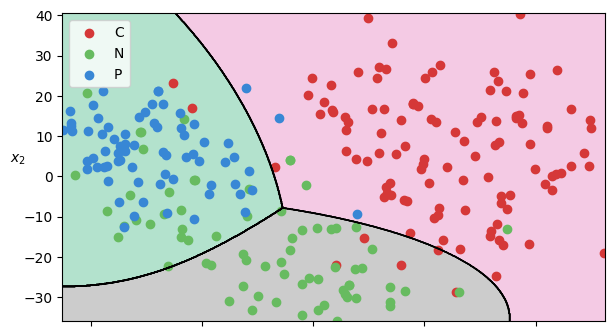

In [34]:
plt.figure(figsize=(7,4))
plot_decision_boundaries_without_points(gm, X2D, show_centroids=False,
                         show_xlabels=False)

for category, color in zip(categories, colors):
    indices = y_train == category
    plt.scatter(X2D[indices, 0], X2D[indices, 1], c=color, label=category)

plt.legend()
plt.show()

*   Upon also trying k = 4 as the number of clusters, k = 3 ended up doing a better job. Visually, it looks like the images are well grouped into 3 distinct clusters.

In [35]:
gen_reduced, y_gen = gm.sample(n_samples=20)
gen_img = pca.inverse_transform(gen_reduced)

In [36]:
gen_img.shape

(20, 65536)

In [37]:
def plot_img(instances, images_per_row=5, **options):
    size = 256
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1

    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)

    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    plt.show()

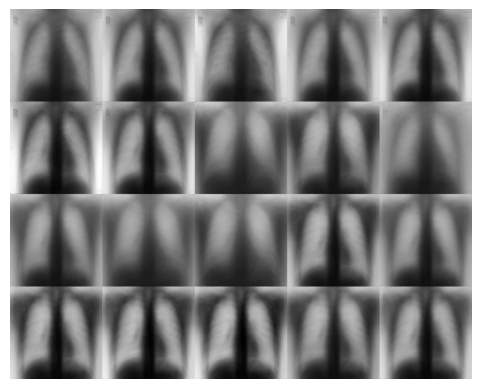

In [38]:
plot_img(gen_img)

* The quality of the images is impacted by dimensionality reduction. Yet, major differences are apparent such as image contrast.
* The following are 20 images in their original dimensions:

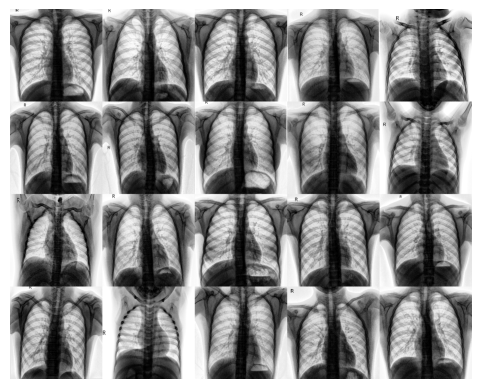

In [39]:
plot_rocks(X[:20])

#### Validation data

In [40]:
X_val = []
y_val = []

path = 'drive/MyDrive/Covid19-dataset/test'
val_path = os.listdir(path)

for folder in val_path:
  folder_path = os.path.join(path, folder)
  if os.path.isdir(folder_path):
    for img in os.listdir(folder_path):
        X_val.append(read_image(folder_path + '/' + img))
        if folder[0] == 'C':
            y_val.append('C') # Covid
        elif folder[0] == 'V':
            y_val.append('P') # Pneumonia
        else:
            y_val.append('N') # Normal

In [41]:
# encode y_train and y_val
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.fit_transform(y_val)

#### Feedforward Neural Network

In [72]:
model = keras.Sequential([
    layers.Input(shape = X_train.shape[1:]),
    layers.Reshape((256, 256, 1)),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', padding='same', kernel_initializer='he_normal', strides = 2),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu', padding='same', kernel_initializer='he_normal', strides = 2),
    layers.MaxPooling2D(2),
    layers.Conv2D(128, kernel_size = (3,3), activation='relu', padding='same', kernel_initializer='he_normal', strides = 2),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

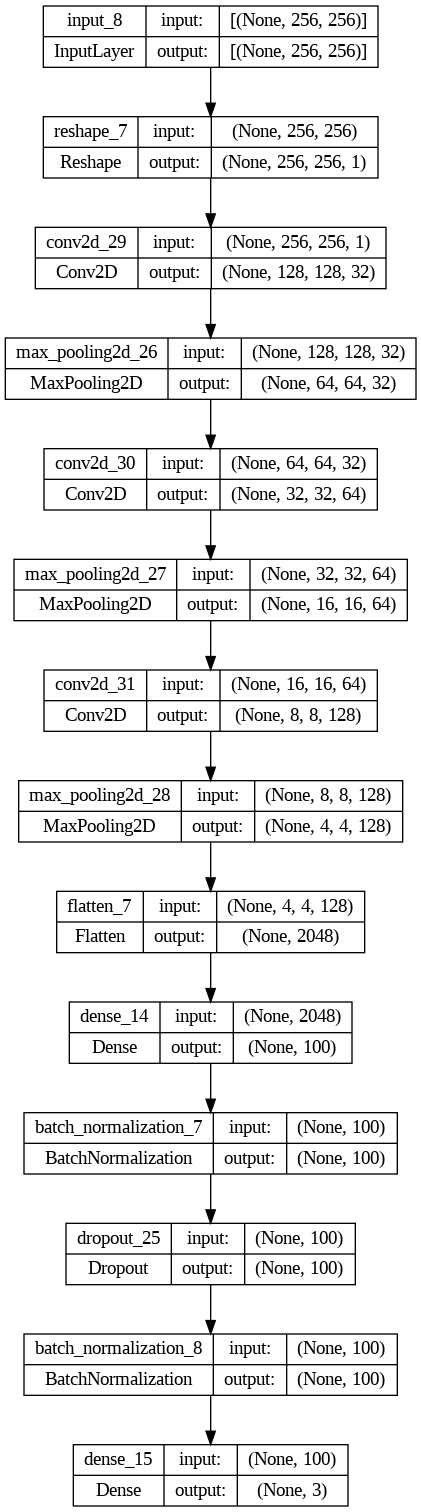

In [73]:
keras.utils.plot_model(model, show_shapes=True)

In [74]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer = optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [75]:
X_train = np.array(X_train)
X_val = np.array(X_val)

In [76]:
start_time = time.time()

history = model.fit(X_train,
                    y_train,
                    epochs = 100,
                    validation_data = (X_val, y_val))

end_time = time.time()
training_time = end_time - start_time

Epoch 1/100
8/8 [==============================] - 5s 438ms/step - loss: 1.1896 - accuracy: 0.4542 - val_loss: 1.9003 - val_accuracy: 0.3030
Epoch 2/100
8/8 [==============================] - 5s 669ms/step - loss: 0.7265 - accuracy: 0.6534 - val_loss: 2.2345 - val_accuracy: 0.3030
Epoch 3/100
8/8 [==============================] - 5s 592ms/step - loss: 0.5241 - accuracy: 0.7809 - val_loss: 2.2542 - val_accuracy: 0.3030
Epoch 4/100
8/8 [==============================] - 3s 390ms/step - loss: 0.4271 - accuracy: 0.8406 - val_loss: 2.1236 - val_accuracy: 0.3030
Epoch 5/100
8/8 [==============================] - 3s 404ms/step - loss: 0.3558 - accuracy: 0.8526 - val_loss: 1.9823 - val_accuracy: 0.3182
Epoch 6/100
8/8 [==============================] - 4s 548ms/step - loss: 0.3047 - accuracy: 0.8884 - val_loss: 1.8446 - val_accuracy: 0.3182
Epoch 7/100
8/8 [==============================] - 5s 689ms/step - loss: 0.3098 - accuracy: 0.8884 - val_loss: 1.7284 - val_accuracy: 0.3182
Epoch 8/100
8

#### Training time

In [77]:
print("Training time = ", float("{:.2f}".format(training_time)), "seconds")

Training time =  443.77 seconds


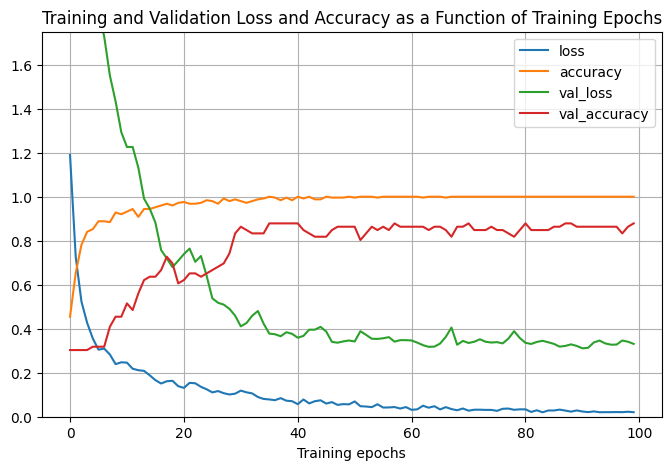

In [78]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.75)
plt.title("Training and Validation Loss and Accuracy as a Function of Training Epochs")
plt.xlabel("Training epochs")
plt.show()

In [79]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_7 (Reshape)         (None, 256, 256, 1)       0         
                                                                 
 conv2d_29 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 8, 8, 128)        